# Multivariate Time Series Forecasting (LSTM)

In [2]:
import yfinance as yf 
import pandas as pd
import numpy as np 
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_validate,StratifiedKFold,GridSearchCV,train_test_split  
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import r2_score, mean_squared_error

2024-05-23 14:37:13.876487: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-23 14:37:13.900326: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 14:37:14.283833: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load Data and Preprocess

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

def get_files_path(files_name):
    files_path = []
    for root, dirs, files in os.walk('../data/'):
        for file in files:
            if file.endswith(files_name):
                files_path.append(os.path.join(root, file))
    return sorted(files_path)

def get_Sn_cell_path(files_name, n):
    csv_files = get_files_path(files_name)
    if n == 'all':
        return csv_files
    return [path for path in csv_files if n in path]

FILES = {
    'BMS':'_BMS_influxdb_data.csv',
    'voltage':'_voltage_influxdb_data.csv',
    'temperature':'temperature_influxdb_data.csv'
}

SnCELL =['all', 'S1_cell', 'S2_cell', 'S3_cell', 'S4_cell', 'S5_cell', 'S6_cell']

def load_data(files):
    data = [pd.read_csv(file, index_col=[0]) for file in files]
    df = pd.concat(data, ignore_index=True)

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.sort_values('timestamp', inplace=True)

    df = df[['timestamp','SOH', 'System voltage', 'System Current', 'SOC']]
     
    df['timestamp'] = df['timestamp'].dt.floor('s')
    df = df[~df['timestamp'].duplicated(keep='first')]
    df = df.set_index('timestamp').resample('1T').first().reset_index()
    df = df.dropna(subset=['System voltage'])
    df = df[df['System voltage'] != 0]
    return df

In [3]:
bms_files_path = get_files_path(FILES['BMS'])
df = load_data(bms_files_path)
df.head()

/tmp/ipykernel_2198671/1249349407.py:42: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.set_index('timestamp').resample('1T').first().reset_index()


,timestamp,SOH,System voltage,System Current,SOC
0,2023-06-09 16:00:00+00:00,983.0,13709.0,73.0,617.0
1,2023-06-09 16:01:00+00:00,983.0,13535.0,282.0,615.0
2,2023-06-09 16:02:00+00:00,983.0,13658.0,57.0,615.0
3,2023-06-09 16:03:00+00:00,983.0,13601.0,106.0,613.0
4,2023-06-09 16:04:00+00:00,983.0,13618.0,12.0,612.0


In [4]:
input_= df[[i for i in df.columns if i not in ['timestamp']]] 
target = df['SOH'].to_numpy() # kita akan prediksi Temperatur

# data time series tidak boleh di shuffle. pastikan shuffle = False
X, X_test, y, y_test = train_test_split(input_, target, test_size=0.4, shuffle=False, random_state=2024)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=2024)

print(X_train.shape, X_val.shape, X_test.shape) 
print(y_train.shape, y_val.shape, y_test.shape)

(54396, 4) (13600, 4) (45332, 4)
(54396,) (13600,) (45332,)


In [5]:
# scaling data
preprocessing= ColumnTransformer([
    ('pipe',make_pipeline(StandardScaler()), list(input_.columns))
    ])

X_train_scaled = preprocessing.fit_transform(X_train) 
X_val_scaled = preprocessing.transform(X_val) 
X_test_scaled = preprocessing.transform(X_test) 

In [6]:
# window = 24. artinya dalam 24 jam, kita mencoba untuk prediksi temperatur 1 jam berikutnya
window_len = 10
batch_size = 16
train_gen = TimeseriesGenerator(data=X_train_scaled, targets=y_train, length=window_len, shuffle=False, batch_size=batch_size)
val_gen = TimeseriesGenerator(data=X_val_scaled, targets=y_val, length=window_len, shuffle=False, batch_size=batch_size)
test_gen=TimeseriesGenerator(data=X_test_scaled, targets=y_test, length=window_len, shuffle=False, batch_size=batch_size)

# Modeling

In [7]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(window_len, len(input_.columns)), return_sequences=True))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.ReLU())
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dense(1))

# learning rate scheduler
num_epochs = 30
num_train_steps = len(train_gen) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate=1e-3, end_learning_rate=0.0, decay_steps=num_train_steps)

model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=lr_scheduler),
              metrics=[tf.metrics.RootMeanSquaredError()])

2024-05-23 14:42:26.696898: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-23 14:42:26.697611: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-23 14:42:26.697691: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 256)        │       267,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 513,857 (1.96 MB)

 Trainable params: 513,857 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

model.fit(
    x=train_gen, 
    validation_data=val_gen, 
    shuffle=False, 
    callbacks=[early_stoping],
    batch_size=batch_size,
    epochs=num_epochs
    )

Epoch 1/30


/home/genailab/miniconda3/envs/esa/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-05-23 14:42:40.607995: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


3400/3400 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 844380.9375 - root_mean_squared_error: 918.3578 - val_loss: 573992.8125 - val_root_mean_squared_error: 757.6231
Epoch 2/30
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 513946.5625 - root_mean_squared_error: 716.3331 - val_loss: 321596.2812 - val_root_mean_squared_error: 567.0946
Epoch 3/30
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 280430.2188 - root_mean_squared_error: 528.8848 - val_loss: 150984.1094 - val_root_mean_squared_error: 388.5667
Epoch 4/30
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 125881.0703 - root_mean_squared_error: 353.9577 - val_loss: 50594.8086 - val_root_mean_squared_error: 224.9329
Epoch 5/30
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 38753.4375 - root_mean_squared_error: 195.7559 - val_loss: 7359.9917 - val_root_mean_squared_error: 85.7904
Epoch 6/30
3400/3400 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 4772.1499 - root_mean_squared_error: 67.7934 - val_loss: 30.8735 - val_root_mean_squ

In [10]:
# save model
model.save('lstm_temperature.h5')

# load model
new_model = tf.keras.models.load_model('lstm_temperature.h5')

# Predict

In [11]:
pred = new_model.predict(test_gen).flatten()

2833/2833 ━━━━━━━━━━━━━━━━━━━━ 2s 601us/step


In [12]:
df_result = X_test[window_len:].copy()
df_result['pred'] =  pred 
df_result['timestamp'] = df['timestamp'][X_test.index[0]:].copy()
df_result = df_result[['timestamp','SOH','pred']].set_axis(['timestamp', 'SOH', 'Prediction'],axis=1)
df_result.tail()

,timestamp,SOH,Prediction
119515,2023-08-31 15:55:00+00:00,973.0,975.0
119516,2023-08-31 15:56:00+00:00,973.0,975.0
119517,2023-08-31 15:57:00+00:00,973.0,975.0
119518,2023-08-31 15:58:00+00:00,973.0,975.0
119519,2023-08-31 15:59:00+00:00,973.0,975.0


/home/genailab/miniconda3/envs/esa/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/genailab/miniconda3/envs/esa/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/genailab/miniconda3/envs/esa/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/genailab/miniconda3/envs/esa/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

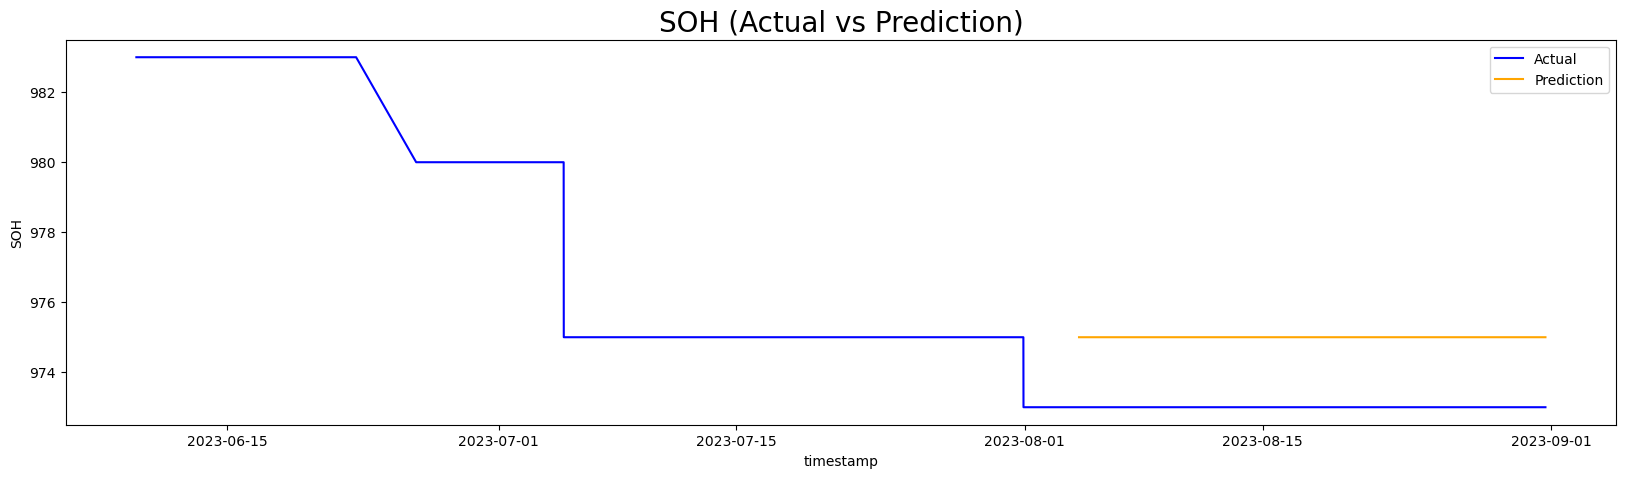

In [24]:
fig = plt.figure(figsize=(20,5)) 
sns.lineplot(data=df, x='timestamp', y='SOH', label='Actual', color='blue')
sns.lineplot(data=df_result, x='timestamp', y='Prediction', label='Prediction', color='orange')
plt.title('SOH (Actual vs Prediction)', size=20)
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print('R2 :',r2_score(y_true=df_result['SOH'], y_pred=df_result['Prediction']))
print('MAE :',mean_absolute_error(y_true=df_result['SOH'], y_pred=df_result['Prediction']))
print('RMSE :',mean_squared_error(y_true=df_result['SOH'], y_pred=df_result['Prediction'],squared=False)) 

R2 : -35.11314741035855
MAE : 1.9446185075680684
RMSE : 1.972114858504985


/home/genailab/miniconda3/envs/esa/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
